In [133]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-olyn8z84
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-olyn8z84
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done


In [134]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [135]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [136]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [137]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [138]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [139]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [140]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [141]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [142]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [143]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [144]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [145]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64    
]

In [146]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [147]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [148]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [149]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])

In [150]:
EPOCHS = 30
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches)

Epoch 1/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - accuracy: 0.7223 - loss: 0.6715 - val_accuracy: 0.8758 - val_loss: 0.3800
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.8894 - loss: 0.2942 - val_accuracy: 0.8913 - val_loss: 0.2983
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.8983 - loss: 0.2667 - val_accuracy: 0.8906 - val_loss: 0.2875
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.9011 - loss: 0.2550 - val_accuracy: 0.8959 - val_loss: 0.2782
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9065 - loss: 0.2390 - val_accuracy: 0.9014 - val_loss: 0.2514
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9087 - loss: 0.2326 - val_accuracy: 0.9010 - val_loss: 0.2745
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.9100 - loss: 0.2280 - val_accuracy: 0.9028 - val_loss: 0.2624
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.9112 - loss: 0.2241 - val_accuracy: 0.9064 - val_loss: 

## Предсказания на 3 картинках

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


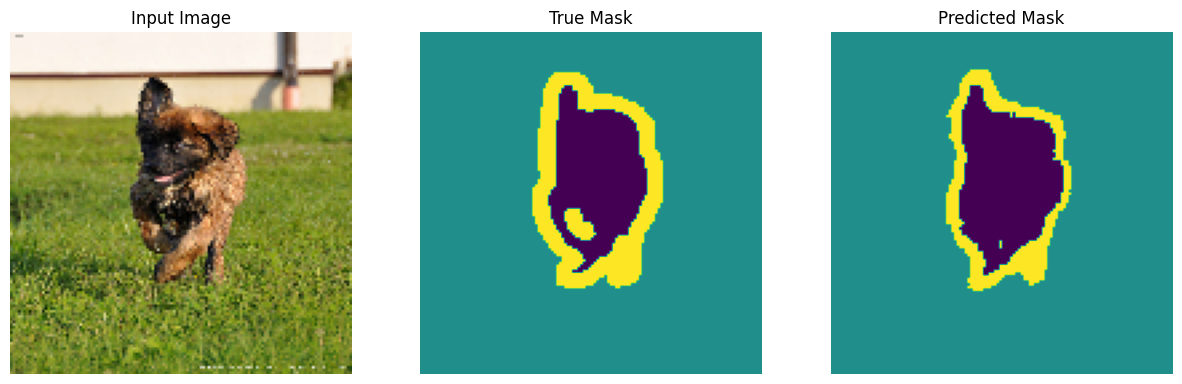

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


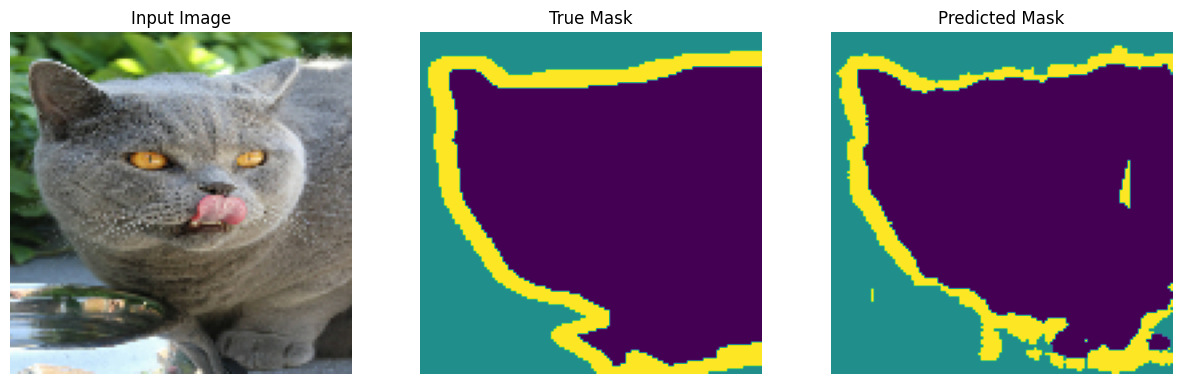

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


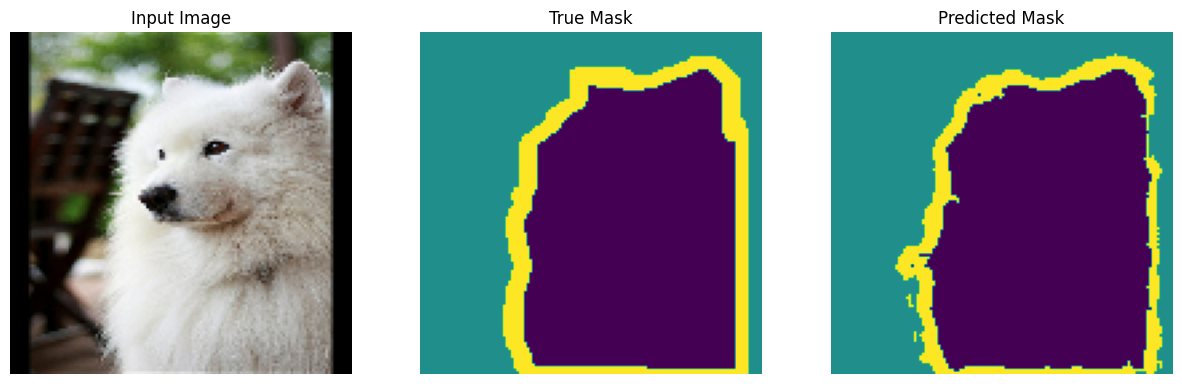

In [151]:
show_predictions(test_batches, 3)